<a href="https://colab.research.google.com/github/Hug0Xu/First-Project/blob/main/Week3_Discussion_Mini_Assignment_Mitigating_bias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 3 Discussion Mini-Assignment

STUDENT NAME(S): Update

# Instructions

The goal of this mini-assignment is to give you a chance to get more familiar with fairness metrics and to detect bias in datasets or ML algorithms and apply simple approaches to mitigitate this bias.

You can work on this mini-assignment in pairs. You will turn in a complete notebook to Gradescope by the deadline. Be sure that you are utilizing dicussion time to work on the assignment and be sure to 'demo' what you have completed by the end of your discussion session. You can continue to work on the mini-assignment and turn it by the due date.


# Biases and Machine Learning

An ML model makes predictions of an outcome for a particular instance. The model makes these preductions based on a training dataset where its attempting to find patterns in the datast to predict a label for a new unseen instance.

For example, lets suppose we are working with a loan application dataset. The dataset has a target binary variable (1 - applicant is likely to repay the loan and 0 - applicant is likely not to repay the loan). The ML model will use the provided features to determine patterns that are closely related to this target variable. However, sometimes the patterns that are found may not be desirable or may even be illegal. For example, a loan repay model may determine that age plays a significat role in the prediction of repayment because the training happends to have better repayment for one age group than for another.

This raises two problems: 1 - the training dataset may not be representative of the true population of people of all age groups, 2 - even if it is representative, it is illegal to base any decision on an applicant's age.






# Task

1. Step 1 - Import the dataset and split into training and test (80/20). In this dataset, we will focus on evaluating fairness with respect to age. Assume that 'age >= 25' is considered 'privileged' and 'age < 25' is considered 'unpriviledged'.  You can also drop the feature 'Personal status and sex' because its a protected attribute too.

2. Step 2 - Next, train an ML model (lets say DecisionTree) on the original dataset and compute fairness metric and highlight the results for the privileged and unpriviledged groups. Include results, graphs and a discussion. **For example, you can generate graphs like above that shows the confusion matrix for the privileged and unprivileged group. **

3. Step 3 - We will now try to mitigate bias by transforming the original dataset. The previous step likley showed that the privileged group was getting more positive outcomes in the training dataset. Since this is not desirable, we are going to try to mitigate this bias in the training dataset so that our model is not susceptible to this bias. This is called pre-processing mitigation and one approach we can take is to reweight the items in the dataset by oversampling or undersampling. Take a look at SMOTE (https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html).

4. Step 4 - Compute fairness metric after training on transformed dataset.  Check how effective it was in removing bias by using the same metric we computed in step 2. Note, bias might not always be removed, we are just reporting on our findings.

*** Note *** If you are a CS/STAT 212 student, then try implemening another bias mitigation approach.


In [ ]:
!pip install ucimlrepo
!pip install imbalanced-learn

In [ ]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
statlog_german_credit_data = fetch_ucirepo(id=144)

# data (as pandas dataframes)
X = statlog_german_credit_data.data.features # features
y = statlog_german_credit_data.data.targets # target variable

# metadata
print(statlog_german_credit_data.metadata)

# variable information
print(statlog_german_credit_data.variables)

{'uci_id': 144, 'name': 'Statlog (German Credit Data)', 'repository_url': 'https://archive.ics.uci.edu/dataset/144/statlog+german+credit+data', 'data_url': 'https://archive.ics.uci.edu/static/public/144/data.csv', 'abstract': 'This dataset classifies people described by a set of attributes as good or bad credit risks. Comes in two formats (one all numeric). Also comes with a cost matrix', 'area': 'Social Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 1000, 'num_features': 20, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Other', 'Marital Status', 'Age', 'Occupation'], 'target_col': ['class'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1994, 'last_updated': 'Thu Aug 10 2023', 'dataset_doi': '10.24432/C5NC77', 'creators': ['Hans Hofmann'], 'intro_paper': None, 'additional_info': {'summary': 'Two datasets are provided.  the original dataset, in the form provided by

In [ ]:
# notice that X uses 'Attribute#' as feature names. Lets rename the columns to make it easier.

# Extract feature names in correct order
featureName = [
    'Status', 'Duration', 'CreditHistory', 'Purpose', 'CreditAmount',
    'Savings', 'employmentSince', 'rate', 'PersonalStatus&Sex',
    'OtherDebtors', 'residenceSince', 'Property', 'Age',
    'installmentPlans', 'Housing', 'numCredits', 'Job',
    'numDependents', 'Telephone', 'foreigneWorker'
]

X.columns = featureName


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import numpy as np

# TODO - Data pre-processing
# 1. Drop protected attribute
X_processed = X.drop(columns=["PersonalStatus&Sex"])

# 2. Identify categorical vs numeric columns
categorical_cols = X_processed.select_dtypes(include=["object", "category"]).columns
numeric_cols = X_processed.select_dtypes(exclude=["object", "category"]).columns

# 3. One-hot encode categorical attributes
X_encoded = pd.get_dummies(
    X_processed,
    columns=categorical_cols,
    drop_first=True  # avoids dummy variable trap
)

# Optional: ensure all values are numeric
X_encoded = X_encoded.astype(float)

In [ ]:
# Some EDA
# Before proceeding, lets just measure positive / negative outcome in the dataset with respect to our Age variable.

import pandas as pd

def percentByAge(X, y, age_threshold=25):
    # Convert y to Series
    y_series = y.iloc[:, 0] if isinstance(y, pd.DataFrame) else pd.Series(y)

    # German Credit mapping: 1 = good, 2 = bad ** Need to remap **
    y_binary = y_series.map({1: 1, 2: 0})

    # Combine X and y
    df = X.copy()
    df["outcome"] = y_binary

    # Create age groups
    young = df[df["Age"] <= age_threshold]
    older = df[df["Age"] > age_threshold]

    def print_stats(group, label):
        total = len(group)
        pos_pct = (group["outcome"] == 1).mean() * 100
        neg_pct = (group["outcome"] == 0).mean() * 100

        print(f"{label}")
        print(f"  Positive outcome (1): {pos_pct:.2f}%")
        print(f"  Negative outcome (0): {neg_pct:.2f}%")
        print(f"  Total records: {total}")
        print("-" * 45)

    print(f"Outcome percentages by Age (≤ {age_threshold} vs > {age_threshold})\n")

    print_stats(young, f"Age ≤ {age_threshold}")
    print_stats(older, f"Age > {age_threshold}")

In [ ]:
percentByAge(X, y, age_threshold=25)



Outcome percentages by Age (≤ 25 vs > 25)

Age ≤ 25
  Positive outcome (1): 57.89%
  Negative outcome (0): 42.11%
  Total records: 190
---------------------------------------------
Age > 25
  Positive outcome (1): 72.84%
  Negative outcome (0): 27.16%
  Total records: 810
---------------------------------------------


TODO: What observations do you notice in the dataset? How do you think this pattern in the dataset itself will affect the model?

......
......

In [ ]:
# Step 1
# Split the data into training and testing sets

# Note, here I assumed you encoded X (called it X_ecncoded) to deal with categorical columns.
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)


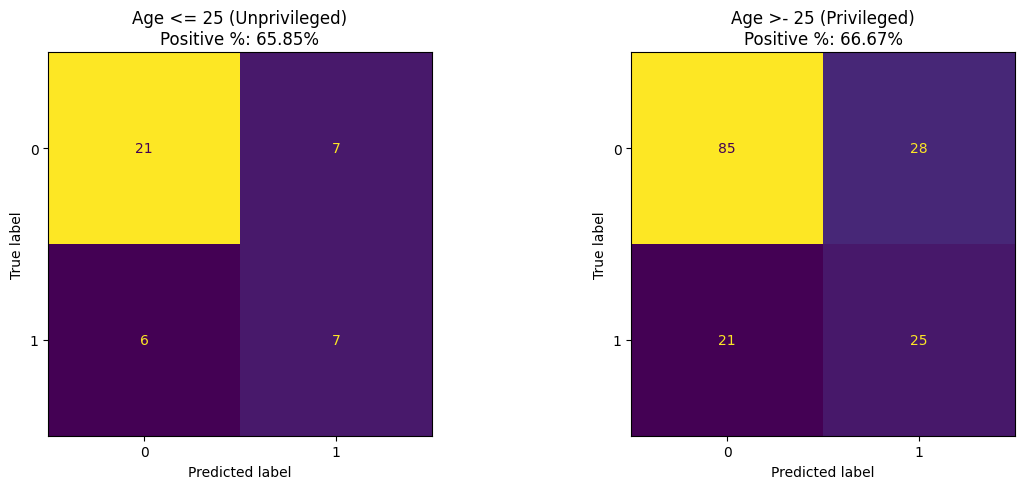

In [20]:
# Step 2
# Train a classifier (replace DecisionTreeClassifier with your desired classifier)
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier

# Train classifier
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

# Predict on test set
y_pred = clf.predict(X_test)

# Evaluate Age values for test set
age_test = X.loc[X_test.index, "Age"]

mask_unpriv = age_test <= 25
mask_priv = age_test > 25

#Check out the positive rates
pos_priv_pred = (y_pred[mask_priv] == 1).mean() * 100
pos_unpriv_pred = (y_pred[mask_unpriv] == 1).mean() * 100

# Confusion matrices for privileged and unprivileged
cm_unpriv = confusion_matrix(y_test[mask_unpriv], y_pred[mask_unpriv])
cm_priv = confusion_matrix(y_test[mask_priv], y_pred[mask_priv])

# Plot side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Unprivileged group
disp_unpriv = ConfusionMatrixDisplay(confusion_matrix=cm_unpriv)
disp_unpriv.plot(ax=axes[0], colorbar=False)
axes[0].set_title("Age ≤ 25 (Unprivileged)")
axes[0].set_title(f"Age <= 25 (Unprivileged)\nPositive %: {pos_unpriv_pred:.2f}%")


# Privileged group
disp_priv = ConfusionMatrixDisplay(confusion_matrix=cm_priv)
disp_priv.plot(ax=axes[1], colorbar=False)
axes[1].set_title("Age > 25 (Privileged)")
axes[1].set_title(f"Age >- 25 (Privileged)\nPositive %: {pos_priv_pred:.2f}%")


plt.tight_layout()
plt.show()



In [ ]:
# Above shows you the confusion matrix for the privileged vs unprivileged groups

# Calculate percentage of positive outcomes for each age group
pos_unpriv = (y_test[mask_unpriv] == 1).mean() * 100
pos_priv = (y_test[mask_priv] == 1).mean() * 100

print("Percentage of positive outcomes (Age ≤ 25)", pos_unpriv)
print("Percentage of positive outcomes (Age > 25)", pos_priv)

# TODO - based on confusion matrix and Percent og positive outcomes, what do you notice? Is there bias in the model?

In [15]:
from sklearn.utils import resample
#Upsample unpreviliged
age_filter_priv = X_train['Age'] >= 25
age_filter_unpriv = X_train['Age'] <= 25

X_train_priv = X_train[age_filter_priv]
y_train_priv = y_train[age_filter_priv]

X_train_unpriv = X_train[age_filter_unpriv]
y_train_unpriv = y_train[age_filter_unpriv]

# Upsample unprivileged
X_train_unpriv_upsampled, y_train_unpriv_upsampled = resample(
    X_train_unpriv, y_train_unpriv,
    replace=True,
    n_samples=len(X_train_priv),
    random_state=42
)
 #combine
X_train_balanced = pd.concat([X_train_priv, X_train_unpriv_upsampled])
y_train_balanced = pd.concat([y_train_priv, y_train_unpriv_upsampled])

print (X_train.shape, X_train_balanced.shape) # number of new records added to dataset


(800, 45) (1366, 45)


After upsampling unprivileged group:
Age > 25 (Privileged) positive %: 69.18%
Age <= 25 (Unprivileged) positive %: 53.66%



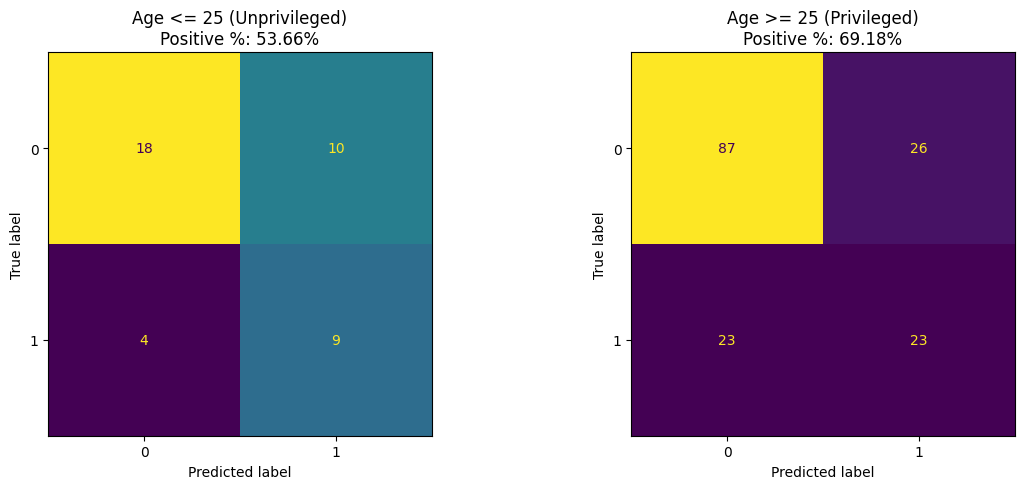

In [19]:
#reuse code from above
# Train classifier
clf_balanced = DecisionTreeClassifier(random_state=67)
clf_balanced.fit(X_train_balanced, y_train_balanced)

# Predict on test set
y_pred_balanced = clf_balanced.predict(X_test)

# Evaluate Age values for test set
age_test = X.loc[X_test.index, "Age"]

mask_unpriv = age_test <= 25
mask_priv = age_test > 25

# Confusion matrices for privileged and unprivileged
cm_unpriv = confusion_matrix(y_test[mask_unpriv], y_pred_balanced[mask_unpriv])
cm_priv = confusion_matrix(y_test[mask_priv], y_pred_balanced[mask_priv])

#find positive outcome rate
pos_priv_pred_bal = (y_pred_balanced[mask_priv] == 1).mean() * 100
pos_unpriv_pred_bal = (y_pred_balanced[mask_unpriv] == 1).mean() * 100

print(f"After upsampling unprivileged group:")
print(f"Age > 25 (Privileged) positive %: {pos_priv_pred_bal:.2f}%")
print(f"Age <= 25 (Unprivileged) positive %: {pos_unpriv_pred_bal:.2f}%\n")

# Plot side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Unprivileged group
disp_unpriv = ConfusionMatrixDisplay(confusion_matrix=cm_unpriv)
disp_unpriv.plot(ax=axes[0], colorbar=False)
axes[0].set_title("Age ≤ 25 (Unprivileged)")
axes[0].set_title(f"Age <= 25 (Unprivileged)\nPositive %: {pos_unpriv_pred_bal:.2f}%")

# Privileged group
disp_priv = ConfusionMatrixDisplay(confusion_matrix=cm_priv)
disp_priv.plot(ax=axes[1], colorbar=False)
axes[1].set_title("Age > 25 (Privileged)")
axes[1].set_title(f"Age >= 25 (Privileged)\nPositive %: {pos_priv_pred_bal:.2f}%")

plt.tight_layout()
plt.show()

In [ ]:
# TODO - Step 4

# Generate fairness metrics (like percent of positive rate) on transformed dataset. Did it change the results at all?

# Conclusions

After upsampling the unprivileged group, I found that the positive rate went down. Before upsampling, the positive rates of both groups were about the same, but after upsampling, it can be concluded that the positive rate for the unprivileged group is a about 16% lower than the privileged group.

# References / Disclosures

I referenced the lecture example to get a good example of what to do.